In [10]:
from skimage.segmentation import slic
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
import cv2
import numpy as np
import torch.nn.init
import matplotlib.pyplot as plt
import random
import warnings
import os
from scipy import io

In [18]:
use_cuda = torch.cuda.is_available()

In [19]:
# CNN model
class MyNet(nn.Module):
    def __init__(self,input_dim, nChannel=100, nConv=2):
        self.nChannel = nChannel
        self.nConv = nConv
        
        
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(input_dim, self.nChannel, kernel_size=3, stride=1, padding=1 )
        self.bn1 = nn.BatchNorm2d(self.nChannel)
        self.conv2 = nn.ModuleList()
        self.bn2 = nn.ModuleList()
        for i in range(self.nConv-1):
            self.conv2.append( nn.Conv2d(self.nChannel, self.nChannel, kernel_size=3, stride=1, padding=1 ) )
            self.bn2.append( nn.BatchNorm2d(self.nChannel) )
        self.conv3 = nn.Conv2d(self.nChannel, self.nChannel, kernel_size=1, stride=1, padding=0 )
        self.bn3 = nn.BatchNorm2d(self.nChannel)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu( x )
        x = self.bn1(x)
        for i in range(self.nConv-1):
            x = self.conv2[i](x)
            x = F.relu(x)
            x = self.bn2[i](x)
        x = self.conv3(x)
        x = self.bn3(x)
        return x

In [20]:
def model_run(model, im, nChannel=100, lr=0.05, maxIter=200, visualize=1, compactness=10, num_superpixels=1000, minLabels=10, verbose=1):
    """
    model = model 
    lr = lr
    maxIter = maxIter
    visualize = visualize
    minLabels = minLabels
    compactness = compactness
    num_superpixels = num_superpixels
    """
    
    loss_list = []
    
    # load image
    
    im = im
    
    im_shape_0 = im.shape[0]
    im_shape_1 = im.shape[1]
    
    data = torch.from_numpy(np.array([im.transpose((2, 0, 1)).astype('float32')/256.]) )
    if use_cuda:
        data = data.cuda()
    data = Variable(data)

    # slic
    ## labels에는 해당 픽셀이 속한 슈퍼픽셀의 레이블(즉, 슈퍼픽셀의 ID)이 저장된다.
    labels = slic(im, compactness=compactness, n_segments=num_superpixels)
    labels = labels.reshape(im.shape[0]*im.shape[1]) # 그냥 1차원으로 폈다.
    u_labels = np.unique(labels)

    ## 각 슈퍼픽셀마다 해당 슈퍼픽셀을 할당하는 픽셀들 위치를 l_inds에 저장하고 있다.
    l_inds = []
    for i in range(len(u_labels)):
        l_inds.append(np.where(labels == u_labels[i])[0])

    # train
    if use_cuda:
        model.cuda()
    model.train()
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # 랜덤하게 색을 결정한다.
    label_colours = np.random.randint(255,size=(100,3))

    for batch_idx in range(maxIter):
        # forwarding
        optimizer.zero_grad()
        # output.shape = (im.shape[0]*imshape[1], nChannel)
        outputs = model(data)[0]
        # 차원을 치완하고 순서에 맞게 재배열하는 과정
        output = outputs.permute(1, 2, 0).contiguous().view(-1, nChannel) 
        # 위에서 shape이 (im.shape[0]*im.shape[1], 100) 으로 변했는데 이유는 view(-1, nChannel)이 텐서를 
        #그냥 저 형태로 continuous하게 재배열한다.

        # axis=1(nChannel 모델이 예측하는 cluster 라벨)max 적용, 100개 중에 max값인 index가 target에 저장된다.               
        # 즉, 모델의 예측된 클래스 라벨
        ignore, target = torch.max(output, 1) 

        im_target = target.data.cpu().numpy()
        nLabels = len(np.unique(im_target))  # unique한 index개수 nLabels에 저장

        ## 시각화
        if visualize:
            im_target_rgb = np.array([label_colours[c % 100] for c in im_target])
            im_target_rgb = im_target_rgb.reshape(im.shape).astype(np.uint8)
            cv2.imshow("output", im_target_rgb)
            cv2.waitKey(10)

        # superpixel refinement
        # TODO: use Torch Variable instead of numpy for faster calculation
        for i in range(len(l_inds)):

            # im_target이 각 픽셀이 어느 라벨(cluster 라벨에 해당하는지 예측하고 있는데
            # l_inds는 각 슈퍼픽셀에 해당하는 픽셀들의 위치가 저장돼있다.
            # labels_per_sp는 각 슈퍼픽셀에 해당하는 픽셀들으 위치에 있는 예측하는 cluster라벨을 가져와서 
            # 저장하는 중이다.
            # 예를 들어서 1번 superpixel에 해당하는 위치의 픽셀들이 예측하는 cluster라벨을 
            # labels_per_sp에 저장한다.
            labels_per_sp = im_target[l_inds[i]]

            # 각 픽셀에서 예측하는 cluster라벨이 있을텐데 그것들의 unique값을 저장한다.
            u_labels_per_sp = np.unique(labels_per_sp)
            hist = np.zeros(len(u_labels_per_sp))

            # 각 라벨마다 개수가 몇개인지 count하고 있다.
            for j in range(len(hist)):
                hist[j] = len(np.where(labels_per_sp == u_labels_per_sp[j])[0])

            # argmax로 그 중 가장 많이 차지하는 놈 == u_labels_per_sp[np.argmax(hist)]
            # 을 im_target 즉, 이미지 모양(안에 내용물은 cluster 라벨)에 개수가 가장 많은 cluster라벨로
            # 바꿔준다.
            im_target[l_inds[i]] = u_labels_per_sp[np.argmax(hist)]

        target = torch.from_numpy(im_target)

        if use_cuda:
            target = target.cuda()
        target = Variable(target)

        # loss_fn = crossentropy 인데 원본사진이랑에서 각 픽셀이 예측한 cluster라벨이랑, k-means이후 refinment를 한 이후 cluster라벨리알 비교한거임
        loss = loss_fn(output, target)
        loss_list.append(loss)
        loss.backward()
        optimizer.step()
        
        if verbose==1:
            #print (batch_idx, '/', maxIter, ':', nLabels, loss.data[0])
            if batch_idx%100 == 0:
                print(batch_idx, '/', maxIter, ':', nLabels, loss.item())
        
        # 이거 안하면 과적합이 심하게 발생한다.
        # 모델이 cluster label의 개수를 상당히 적게 평가하는 경향이 있다.
        # 예를 들어서 minlabels를 10으로 해도 몇 번 학습을 학 나면 예측하는 label의 개수가 2, 3 개가 된다.
        # 이런 문제점을 해결할 방법을 찾아야 하는데 아직 못찾고 있다.
        if nLabels <= minLabels:
            #print("nLabels", nLabels, "reached minLabels", minLabels, ".")
            break
    
    output = model(data)[0]
    output = output.permute(1, 2, 0).contiguous().view(-1, nChannel)
    ignore, target = torch.max(output, 1)

    """
    # save output image
    if not visualize:
        output = model(data)[0]
        output = output.permute(1, 2, 0).contiguous().view(-1, nChannel)
        ignore, target = torch.max(output, 1)
        im_target = target.data.cpu().numpy()
        im_target_rgb = np.array([label_colours[c % 100] for c in im_target])
        im_target_rgb = im_target_rgb.reshape(im.shape).astype(np.uint8)
    cv2.imwrite("output.png", im_target_rgb)
    """
    
    target = target.reshape(im_shape_0, im_shape_1)
    
    return target, model, loss_list

In [21]:
def model_train(model, train, label=0, infer=False, minlabels=10):
    
    loss_list2 = []
    
    # train code
    # 비지도 학습이여서 label data가 없어도 된다.
    
    for i in range(train.shape[0]):

        # minlabels는 하이퍼 파라미터인데 이것을 이미지에서 추론해보자
        # 각 RGB값의 std의 평균을 10으로 나눈 몫으로 두자
        # 분산을 사용하는 이유는 색에 따라서 cluster label이 달라질텐데 분산이 이를 반영한다고 본다.
        a1 = train[i].transpose(2, 0, 1)
        
        if infer:
            minlabels = int(np.mean([np.std(a1[0]), np.std(a1[1]), np.std(a1[2])])//10) + 4
        
        target, model, loss_list = model_run(model, train[i], verbose=0, visualize=1, minLabels=minlabels)
        loss_list2.extend(loss_list)
    
    return target, model, loss_list2

In [22]:
# 모델이 예측하는 값이 각 픽셀이 개인지 아니면 배경인지 예측하는것이 아니라 그냥 물체 1, 2, 3 ...으로 예측하는 모델이다.
# 그래서 일반적인 방법으로 miou를 계산할 수 없다.
# 그래서 굉장히 억지스럽게 계산하는 과정이기 때문에 추천하지는 않는다.
"""
간략히 요약하자면 모델의 예측값에서 unique한 label들을 for 문을 돌린다.
각 predict_label과 real_label을 비교하면서 얼마나 겹치는지 계산한다.
그 중에서 max 값인 iou값을 저장한다.
엄청 억지스럽게 계산하고 있다.
"""

def calculate_miou(model, train, label):

    iou_list = []

    for idx in range(train.shape[0]):

        #if idx%2==0:
        #    print(f"{idx}/{train.shape[0]} average_iou:_{idx} ", np.mean(iou_list))

        im = train[idx]
        data = torch.from_numpy( np.array([im.transpose( (2, 0, 1) ).astype('float32')/255.]) )
        data = Variable(data)
        output = model( data )[ 0 ]
        ignore, target = torch.max( output, 0 )
        inds = target.data.cpu().numpy().reshape( (im.shape[0], im.shape[1]) )
        
        model_label_imgage = inds

        # 모델값과 target값의 라벨을 unique시킨걸 저장한다.
        predict_unique_label = np.unique(model_label_imgage)
        target_unique_label = np.unique(label[idx])


        # 나중에 모델의 라벨이 target의 어느 라벨과 같다고 생각할 것인지 pair[11, 13]을 저장한다.
        label_match_list = []

        # 모델의 유니크한 라벨 개수만큼 반복문을 돌린다.
        for i in range(len(predict_unique_label)):

            # 특정 라벨과 같은 TF image를 반환한다.
            predict_TF_image = (model_label_imgage==predict_unique_label[i])

            # 나중에 어느 pair가 가장 좋은지 일치하는 개수를 list1에 저장한다.
            list1 = []

            # 단순히 순서대로 돌리면 문제가 생겨서 랜덤하게 비교하도록 한다.
            list2 = list(range(len(target_unique_label)))
            random.shuffle(list2)
            for s in list2:

                # target의 특정 라벨값과 같은 TF image를 반환한다.
                target_TF_image = (label[idx]==target_unique_label[s])

                # predict_TF 랑 target_TF 랑 어느정도 일치하는지 계산한다.
                TF_sum = np.sum(np.array(np.logical_and(predict_TF_image, target_TF_image)))

                # 일치하는 픽셀 개수를 list1에 저장한다.
                list1.append(TF_sum)

            # 최대값이 되는 pair를 찾는 과정이다.
            mx = max(list1)
            mx_idx = list1.index(mx)

            # 최대가 되는 pair를 label_match_list에 저장한다.
            label_match_list.append([predict_unique_label[i], target_unique_label[s]])

        # 각 pair들이 얼마나 일치하는지 검사하고 list2에 저장한다.
        list2 = []

        for j in range(len(label_match_list)):
            list2.append(np.sum(label[idx]==np.where(model_label_imgage==label_match_list[i][0], label_match_list[i][1], 0)))


        # iou를 계산한다.
        iou = sum(list2)/(model_label_imgage.shape[0]*model_label_imgage.shape[1])
        iou_list.append(iou)

    #print("average_iou: ", np.mean(iou_list))
    
    return np.mean(iou_list)

In [23]:
train_data = np.load("train_data.npy")
label_data = np.load("label_data.npy")

In [24]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(train_data[:], label_data[:], test_size=0.2)
model = MyNet(3)
ignore, model, train_loss_list1 = model_train(model, X_train, infer=False)
int_miou1 = calculate_miou(model, X_test, Y_test)

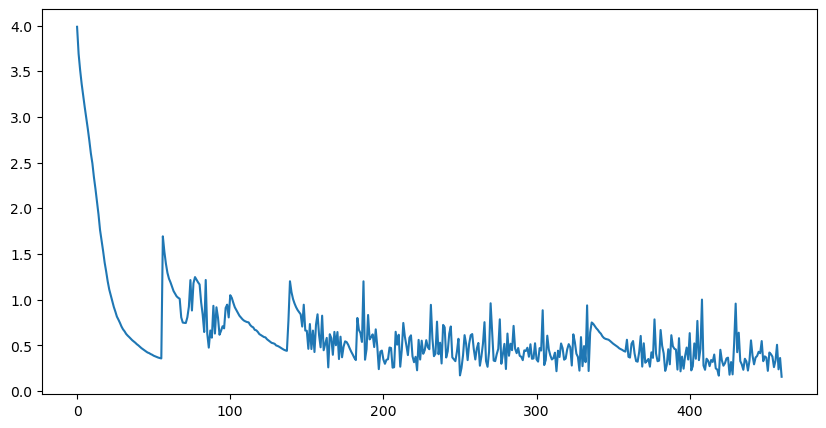

In [119]:
plt.figure(figsize=(10, 5))
plt.plot(list(map(float, train_loss_list1)))
#plt.savefig('defult_loss.png')